In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.style.use('poster')
import beam.calc.electron as ecalc
from lens import profile
from scipy.optimize import minimize
import scipy.constants as const
me = const.physical_constants['electron mass energy equivalent in MeV'][0]
from matplotlib.ticker import FormatStrFormatter
from vsim import plot
from vsim import load
from vsim import analyze
import matplotlib.colors as colors
e = const.physical_constants['elementary charge'][0]

green = '#228833'
purple = '#AA3377'
cyan = '#33BBEE'
red = '#CC3311'
yellow = '#CCBB44'
orange = '#EE7733'
blue = '#0077BB'
magenta = '#EE3377'
# Not from the color palette
grey = '#444444'
denSize = 18
folder = 'LPAW-2019/'

In [2]:
# Run the matched simulation for the animation
import numpy as np
from beam.beams import electronbeam
import matplotlib.pyplot as plt
from beam import interactions
from ionization import ionization
from lens import profile
import beam.calc.electron as ecalc
import scipy.constants as const

# Need to fix path
path = folder
Nz = 2000
s = np.linspace(0, 0.8, Nz, dtype='double')
z = s*1e6
ne = 0.5*np.ones(Nz)
# Now we can test my code and see if it is different
kb = 5.95074e4 * np.sqrt(ne[0])/np.sqrt(2*20000)
betaBeam = 25e-3
alphaBeam = 0
electronParams = {
    'name' : 'Ramp_Paper',
    'path' : path,
    'load' : False,
    'N' : 50000,
    'gamma' : 20000,
    'emittance' : 5.0e-6,
    'betax' : betaBeam,
    'betay' : betaBeam,
    'alphax' : alphaBeam,
    'alphay' : alphaBeam,
    'sigmaz' : 5e-6,
    'dE' : 0.02
}

beam = electronbeam.GaussianElectronBeam(electronParams)
#beam = electronbeam.ElectronBeam(electronParams)
#beam.plot_current_phase()

class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return 0.5*np.ones(Nz)
    def dgammadz(self, ne):
        return 0.0
    
plasmaDen = plasmaCls()
dumpPer = 1
interactions.electron_plasma(beam, plasmaDen, z, dumpPer, 1)
beta, alpha, gamma, gb = ecalc.cs_propagation(z*1e-6, ne, betaBeam, alphaBeam, 20000, 0, 0.5)
print(kb)

210.3904303539018


In [3]:
# Grab the dump we are interested in
def get_data(ind):
    ptcls, z = beam.load_ptcls(ind)
    ptx = ptcls[:, 0]*1e6
    ptxp = ptcls[:, 1]*1e3
    gamma = ptcls[:, 5]
    sort = np.argsort(gamma)
    ptx = ptx[sort]
    ptxp = ptxp[sort]
    gamma = gamma[sort]
    delta = (gamma/20000 - 1)*100
    return ptx, ptxp, delta

def calc_em(x, xp):
    dx = x - np.average(x)
    dxp = xp - np.average(xp)
    # Calculate the RMS sizes and the correlation
    sigmax2 = np.average(dx**2)
    sigmaxp2 = np.average(dxp**2)
    sigmaxxp = np.average(dx*dxp)
    ex = np.sqrt(sigmax2*sigmaxp2 - sigmaxxp**2)
    beta = sigmax2/ex
    alpha = -sigmaxxp/ex
    return beta, alpha, ex

# Get the first piece of data
ptx, ptxp, gamma = get_data(0)
beta, alpha, ex = calc_em(ptx, ptxp)

# Create the emittance ellipse plot
t = np.linspace(0, 2*np.pi, 300)

# Create the plot
fig = plt.figure(figsize=(12, 10), dpi=300)
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1.2])
ax1 = plt.subplot(gs[0, 0])
plt.scatter(ptx, ptxp, c=gamma, cmap=plt.cm.get_cmap('jet'), 
                      alpha=0.5, marker='o', s=1.0)
plt.plot(2*np.sqrt(beta*ex)*np.cos(t), 2*np.sqrt(ex/beta)*(-alpha*np.cos(t)+np.sin(t)), 'w--')

plt.ylabel(r"x' (mrad)")
#plt.xlabel(r'x ($\mathrm{\mu m}$)')
#plt.grid(True)
plt.xlim(-10, 10)
plt.tick_params(top=False,bottom=True,left=True,direction='in')
plt.text(-8, 1.5, r'Unmatched' % (4*ex))
plt.text(-8, -1.75, r'$\epsilon_0=%0.2f\,\mathrm{\mu m\,mrad}$' % (4*ex))

# Get the first piece of data
ptx, ptxp, gamma = get_data(1770)
beta2, alpha2, ex2 = calc_em(ptx, ptxp)

ax2 = plt.subplot(gs[0, 1], sharey=ax1)
plt.scatter(ptx, ptxp, c=gamma, cmap=plt.cm.get_cmap('jet'), 
                      alpha=0.5, marker='o', s=1.0)
plt.plot(2*np.sqrt(beta2*ex2)*np.cos(t), 2*np.sqrt(ex2/beta2)*(-alpha2*np.cos(t)+np.sin(t)), 'k--')
plt.plot(2*np.sqrt(beta*ex)*np.cos(t), 2*np.sqrt(ex/beta)*(-alpha*np.cos(t)+np.sin(t)), 'w--')

# Formatting stuff
cb = plt.colorbar()
cb.set_label(r'$\delta$ (%)')
cb.set_ticks(np.linspace(-2, 2, 5))
#plt.xlabel(r'x ($\mathrm{\mu m}$)')
plt.xlim(-10, 10)
plt.ylim(-2, 2)
plt.tick_params(top=False,bottom=True,left=True,direction='in')
ax1.xaxis.set_ticks([-8, 0, 8])
ax2.xaxis.set_ticks([-8, 0, 8])
plt.text(-8, -1.75, r'$\epsilon_{sat}=%0.2f\,\mathrm{\mu m\,mrad}$' % (4*ex2))

#plt.text(-25, -1, 'Initial Emittance')
#plt.text(-25, 1, 'Final Emittance')
#plt.grid(True)
#plt.tight_layout()
#fig.subplots_adjust(wspace=0)
#plt.setp(fig.axes[1].get_yticklabels(), visible=False)
#plt.savefig(folder+'Chromatic_Emittance.png')
#plt.show()
print('Inital emittance: %0.2f, Final emittance: %0.2f' % (ex, ex2))

Inital emittance: 0.25, Final emittance: 0.68


In [4]:
# Run the matched simulation for the animation
import numpy as np
from beam.beams import electronbeam
import matplotlib.pyplot as plt
from beam import interactions
from ionization import ionization
from lens import profile
import beam.calc.electron as ecalc
import scipy.constants as const

# Need to fix path
path = folder
Nz = 2000
s = np.linspace(0, 0.8, Nz, dtype='double')
z = s*1e6
ne = 0.5*np.ones(Nz)
# Now we can test my code and see if it is different
kb = 5.95074e4 * np.sqrt(ne[0])/np.sqrt(2*20000)
betaBeam = 1/kb
alphaBeam = 0
electronParams = {
    'name' : 'Ramp_Paper',
    'path' : path,
    'load' : False,
    'N' : 50000,
    'gamma' : 20000,
    'emittance' : 5.0e-6,
    'betax' : betaBeam,
    'betay' : betaBeam,
    'alphax' : alphaBeam,
    'alphay' : alphaBeam,
    'sigmaz' : 5e-6,
    'dE' : 0.02
}

beam = electronbeam.GaussianElectronBeam(electronParams)
#beam = electronbeam.ElectronBeam(electronParams)
#beam.plot_current_phase()

class plasmaCls():
    def __init__(self):
        """ Empy init function """
    def get_ne(self, z):
        return 0.5*np.ones(Nz)
    def dgammadz(self, ne):
        return 0.0
    
plasmaDen = plasmaCls()
dumpPer = 1
interactions.electron_plasma(beam, plasmaDen, z, dumpPer, 1)
beta, alpha, gamma, gb = ecalc.cs_propagation(z*1e-6, ne, betaBeam, alphaBeam, 20000, 0, 0.5)
print(kb)

210.3904303539018


In [5]:
# Grab the dump we are interested in
def get_data(ind):
    ptcls, z = beam.load_ptcls(ind)
    ptx = ptcls[:, 0]*1e6
    ptxp = ptcls[:, 1]*1e3
    gamma = ptcls[:, 5]
    sort = np.argsort(gamma)
    ptx = ptx[sort]
    ptxp = ptxp[sort]
    gamma = gamma[sort]
    delta = (gamma/20000 - 1)*100
    return ptx, ptxp, delta

def calc_em(x, xp):
    dx = x - np.average(x)
    dxp = xp - np.average(xp)
    # Calculate the RMS sizes and the correlation
    sigmax2 = np.average(dx**2)
    sigmaxp2 = np.average(dxp**2)
    sigmaxxp = np.average(dx*dxp)
    ex = np.sqrt(sigmax2*sigmaxp2 - sigmaxxp**2)
    beta = sigmax2/ex
    alpha = -sigmaxxp/ex
    return beta, alpha, ex

# Get the first piece of data
ptx, ptxp, gamma = get_data(0)
beta, alpha, ex = calc_em(ptx, ptxp)

# Create the emittance ellipse plot
t = np.linspace(0, 2*np.pi, 300)

# Create the plot
#fig = plt.figure(figsize=(12, 5), dpi=300)
#gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.2])
ax3 = plt.subplot(gs[1, 0], sharex=ax1)
plt.scatter(ptx, ptxp, c=gamma, cmap=plt.cm.get_cmap('jet'), 
                      alpha=0.5, marker='o', s=0.5)
plt.plot(2*np.sqrt(beta*ex)*np.cos(t), 2*np.sqrt(ex/beta)*(-alpha*np.cos(t)+np.sin(t)), 'w--')

plt.ylabel(r"x' (mrad)")
plt.xlabel(r'x ($\mathrm{\mu m}$)')
#plt.grid(True)
plt.xlim(-10, 10)
plt.tick_params(top=False,bottom=True,left=True,direction='in')
plt.text(-8, 1.5, r'Matched' % (4*ex))

# Get the first piece of data
ptx, ptxp, gamma = get_data(1770)
beta2, alpha2, ex2 = calc_em(ptx, ptxp)

ax4 = plt.subplot(gs[1, 1], sharey=ax3)
plt.scatter(ptx, ptxp, c=gamma, cmap=plt.cm.get_cmap('jet'), 
                      alpha=0.5, marker='o', s=0.2)
plt.plot(2*np.sqrt(beta2*ex2)*np.cos(t), 2*np.sqrt(ex2/beta2)*(-alpha2*np.cos(t)+np.sin(t)), 'k--')
plt.plot(2*np.sqrt(beta*ex)*np.cos(t), 2*np.sqrt(ex/beta)*(-alpha*np.cos(t)+np.sin(t)), 'w--')

# Formatting stuff
cb = plt.colorbar()
cb.set_label(r'$\delta$ (%)')
cb.set_ticks(np.linspace(-2, 2, 5))
plt.xlabel(r'x ($\mathrm{\mu m}$)')
plt.xlim(-10, 10)
plt.ylim(-2, 2)
plt.tick_params(top=False,bottom=True,left=True,direction='in')
ax3.xaxis.set_ticks([-8, 0, 8])
ax4.xaxis.set_ticks([-8, 0, 8])

#plt.text(-25, -1, 'Initial Emittance')
#plt.text(-25, 1, 'Final Emittance')
#plt.grid(True)
plt.tight_layout()
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0)
plt.setp(fig.axes[1].get_yticklabels(), visible=False)
plt.setp(ax4.get_yticklabels(), visible=False)
plt.savefig(folder+'Chromatic_Emittance.png')
plt.show()
print('Inital emittance: %0.2f, Final emittance: %0.2f' % (ex, ex2))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


Inital emittance: 0.25, Final emittance: 0.25


z0: 45.374537453745376
ne0: 0.01199703251495801
bs: 10.055028400749334
ss: 47.84887020437034


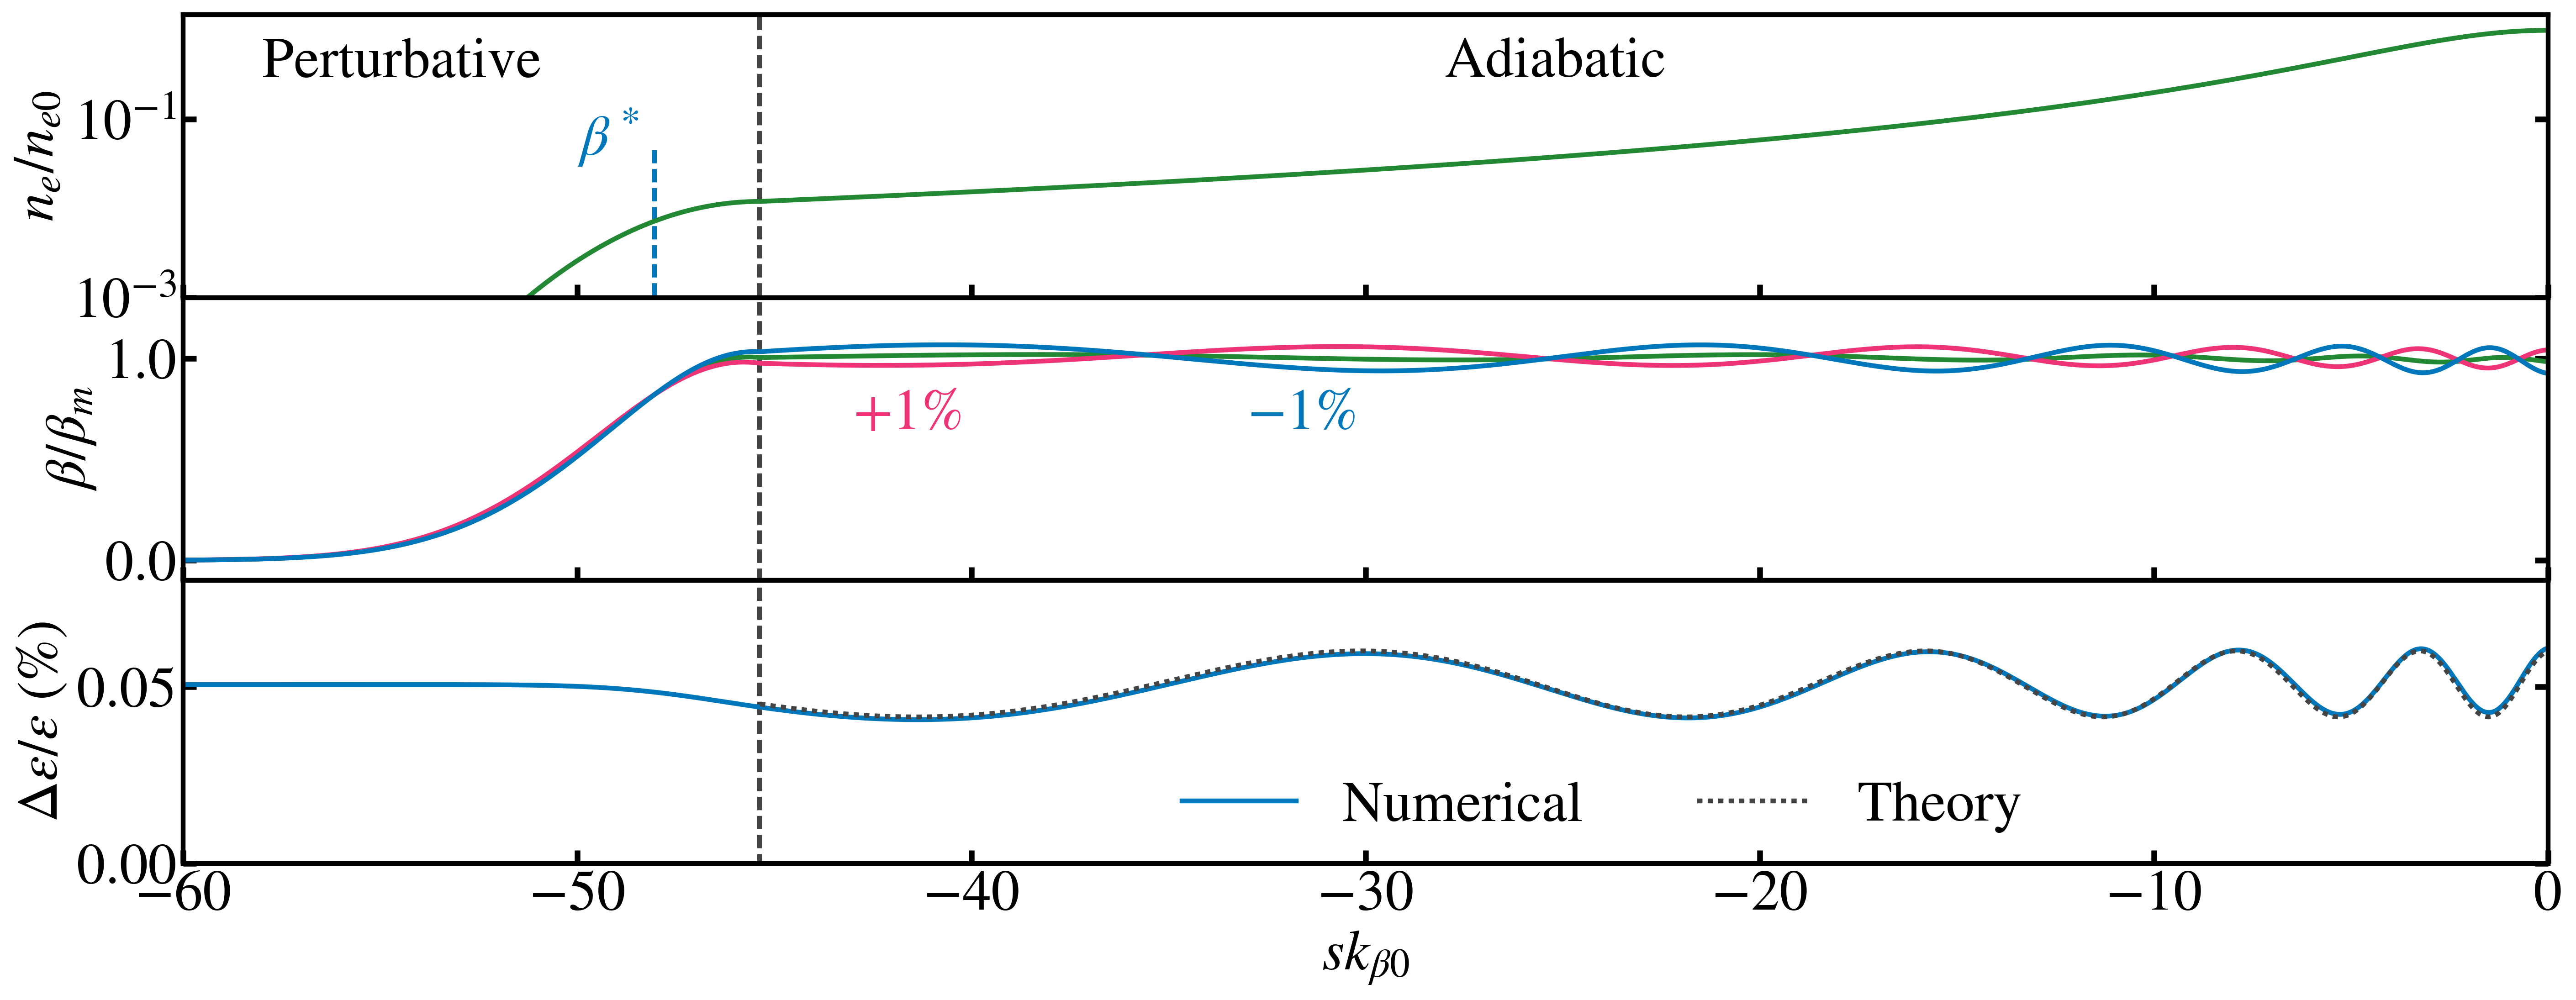

In [6]:
# Beam evolution and emittance growth in a pwfa
# Entrance ramp
N = 10000
beta0 = 1.0
alpha0 = 0.0
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.2
z = np.linspace(0, 100, N)
frac = 1/(1+(a*z)**2)
sel = frac < 0.012
tran = z[sel][0]
print('z0:', tran)
print('ne0:', frac[sel][0])
ztran = z[sel]
# Numerical back propagatin says this is optimal for bs=10
#sigma = 2.541
sigma = 2.645
frac[sel] = frac[sel][0]*np.exp(-(ztran - z[sel][0])**2/(2*sigma**2))
ne = frac*ne0
# Forward propagate to make sure the output is what we expect it to be 
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

# Calculate free space propagation
bs = 1/gamma[-1]
ss = alpha[-1]*bs + 100
betaFree = (z-ss)**2/bs+bs
print('bs:', bs)
print('ss:', ss)

#------------------------------------------
# Create the up ramp and handle the chromatic input beam to see how everything works
Zmin = -100
bs0 = 10
ss = 48.041
delta = 0.01
ii = 5.5
z, dz = np.linspace(Zmin, 0, N, retstep=True)
beta0 = (Zmin+ss)**2/bs0+bs0
alpha0 = -(Zmin+ss)/bs0
frac = np.flip(frac, 0)
ne = frac*ne0
betam = 1/np.sqrt(frac)
# propagate the centroid energy and the extreme energy componenets
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)
g1 = (1+ii**2*delta**2)/bs0
beta0d = 1/g1 + g1*((Zmin+ss)-ii*delta/g1)**2
alpha0d = ii*delta-g1*(Zmin+ss)
beta1, alpha1, gamma1, gb1 = ecalc.cs_propagation(z, ne, beta0d, alpha0d, gb0*(1+delta), dgdz0, ne0)
g1 = (1+ii**2*delta**2)/bs0
beta0d = 1/g1 + g1*((Zmin+ss)+ii*delta/g1)**2
alpha0d = -ii*delta-g1*(Zmin+ss)
betan1, alphan1, gamman1, gbn1 = ecalc.cs_propagation(z, ne, beta0d, alpha0d, gb0*(1-delta), dgdz0, ne0)
sel = np.flip(sel, 0)

M = 500
deltaA = np.linspace(-delta, delta, M)
gb0A = 20000*(1+deltaA)
betaDelta = np.zeros((M, N), dtype='double')
alphaDelta = np.zeros((M, N), dtype='double')
gammaDelta = np.zeros((M, N), dtype='double')
for i in range(M):
    g1 = (1+ii**2*deltaA[i]**2)/bs0
    beta0d = 1/g1 + g1*((Zmin+ss)-ii*deltaA[i]/g1)**2
    alpha0d = ii*deltaA[i]-g1*(Zmin+ss)
    betaDelta[i,:], alphaDelta[i, :], gammaDelta[i, :], gb = ecalc.cs_propagation(z,ne, beta0d,
                                                                                  alpha0d, gb0A[i], dgdz0, ne0)
betaP = np.average(betaDelta, axis=0)
alphaP = np.average(alphaDelta, axis=0)
gammaP = np.average(gammaDelta, axis=0)
eps = np.sqrt(betaP*gammaP-alphaP**2)
theta = np.cumsum(1/betam[np.logical_not(sel)])*dz

m = (1.64199 - 4.95517*ii)/9.06159
p = (-0.327629 + 0.780798*ii)/0.097085
am = a/2
a1 = (0.5 - 0.5*am**2-m-0.5*am**2*m)
a2 = am*(m-p)
a3 = 0.5*(1-am**2)-0.5*m*am**2
W2 = a1**2 + a2**2 + a3**2 + 2*a2*a3*np.sin(2*theta) - 2*a1*a3*np.cos(2*theta)

#plt.plot(deltaA,betaDelta[:,np.logical_not(sel)][:,0])
#plt.show()
#plt.plot(deltaA,alphaDelta[:,np.logical_not(sel)][:,0])
#plt.show()

#--------------------------------------------------
# Plotting
fig = plt.figure(figsize=(19.5, 8), dpi=300)
gs = gridspec.GridSpec(3, 1)

ax0 = plt.subplot(gs[0, 0])
ax0.plot(z, frac, color=green)
ax0.plot([-tran, -tran], [-.05, 1.5], '--', color=grey, zorder=0)
ax0.plot([-ss, -ss], [-.05, 5e-2], '--', color=blue, zorder=0)
ax0.tick_params(top=False,bottom=True,left=True,right=True,direction='in')
plt.ylabel(r'$n_e/n_{e0}$')
plt.yscale('log')
plt.ylim(0.001, 1.5)
#plt.text(-28, 0.85, 'Adiabatic')
#plt.arrow(-29, 0.9, -16.2, 0, head_width=.05, head_length=1.5, linewidth=0.5, fc='k', length_includes_head=True)
#plt.arrow(-17, 0.9, 17, 0, head_width=.05, head_length=1.5, linewidth=0.5, fc='k', length_includes_head=True)
#plt.text(-59, 0.85, 'Perturbative')
plt.text(-28, 0.3, 'Adiabatic')
plt.text(-58, 0.3, 'Perturbative')
plt.text(-50, 4e-2, r'$\beta^*$', color=blue)
plt.minorticks_off()

ax1 = plt.subplot(gs[1, 0], sharex=ax0)
ax1.plot(z, beta/betam, color=green)
ax1.plot(z, beta1/betam, color=magenta)
ax1.plot(z, betan1/betam, color=blue)
ax1.plot([-tran, -tran], [-.2, 1.5], '--', color=grey, zorder=0)
ax1.plot([-tran, -tran], [-.2, 1.5], '--', color=grey, zorder=0)
ax1.tick_params(top=False,bottom=True,left=True,right=True,direction='in')
plt.ylabel(r'$\beta/\beta_{m}$')
plt.text(-43, 0.65, r'$+1\%$', color=magenta)
plt.text(-33, 0.65, r'$-1\%$', color=blue)
plt.ylim(-0.1, 1.3)
ax1.yaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
#plt.text(-28, 0, 'Adiabatic')
#plt.arrow(-29, 0.07, -16.2, 0, head_width=.05, head_length=1.5, linewidth=0.5, fc='k', length_includes_head=True)
#plt.arrow(-17, 0.07, 17, 0, head_width=.05, head_length=1.5, linewidth=0.5, fc='k', length_includes_head=True)
#plt.text(-59, 1.1, 'Perturbative')

ax2 = plt.subplot(gs[2, 0], sharex=ax0)
ax2.plot(z, (eps-1)*1e2)
plt.plot(z[np.logical_not(sel)], 0.5*W2*delta**2*1e2/3, ':', c=grey)
ax2.plot([-tran, -tran], [-.2, 1.5], '--', color=grey, zorder=0)
ax2.tick_params(top=False,bottom=True,left=True,right=True,direction='in')
plt.ylabel(r'$\Delta\epsilon/\epsilon$ (%)')
plt.ylim(0, 0.08)
plt.legend(['Numerical', 'Theory'], bbox_to_anchor=(.6, .2), loc='center', frameon=False, ncol=2)

plt.xlim(-60, 0)
plt.xlabel(r'$sk_{\beta0}$')


plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in fig.axes[:-1]], visible=False)
plt.savefig(folder+'Entrance_Ramp.eps')
plt.savefig(folder+'Entrance_Ramp.png')
plt.show()

In [7]:
# Store the variables we need for the full ramp picture
z_ent = z
beta_ent = beta
frac_ent = frac
ss_ent = ss
bs_ent = bs0

alpha_m= -0.45
23.52485248524853


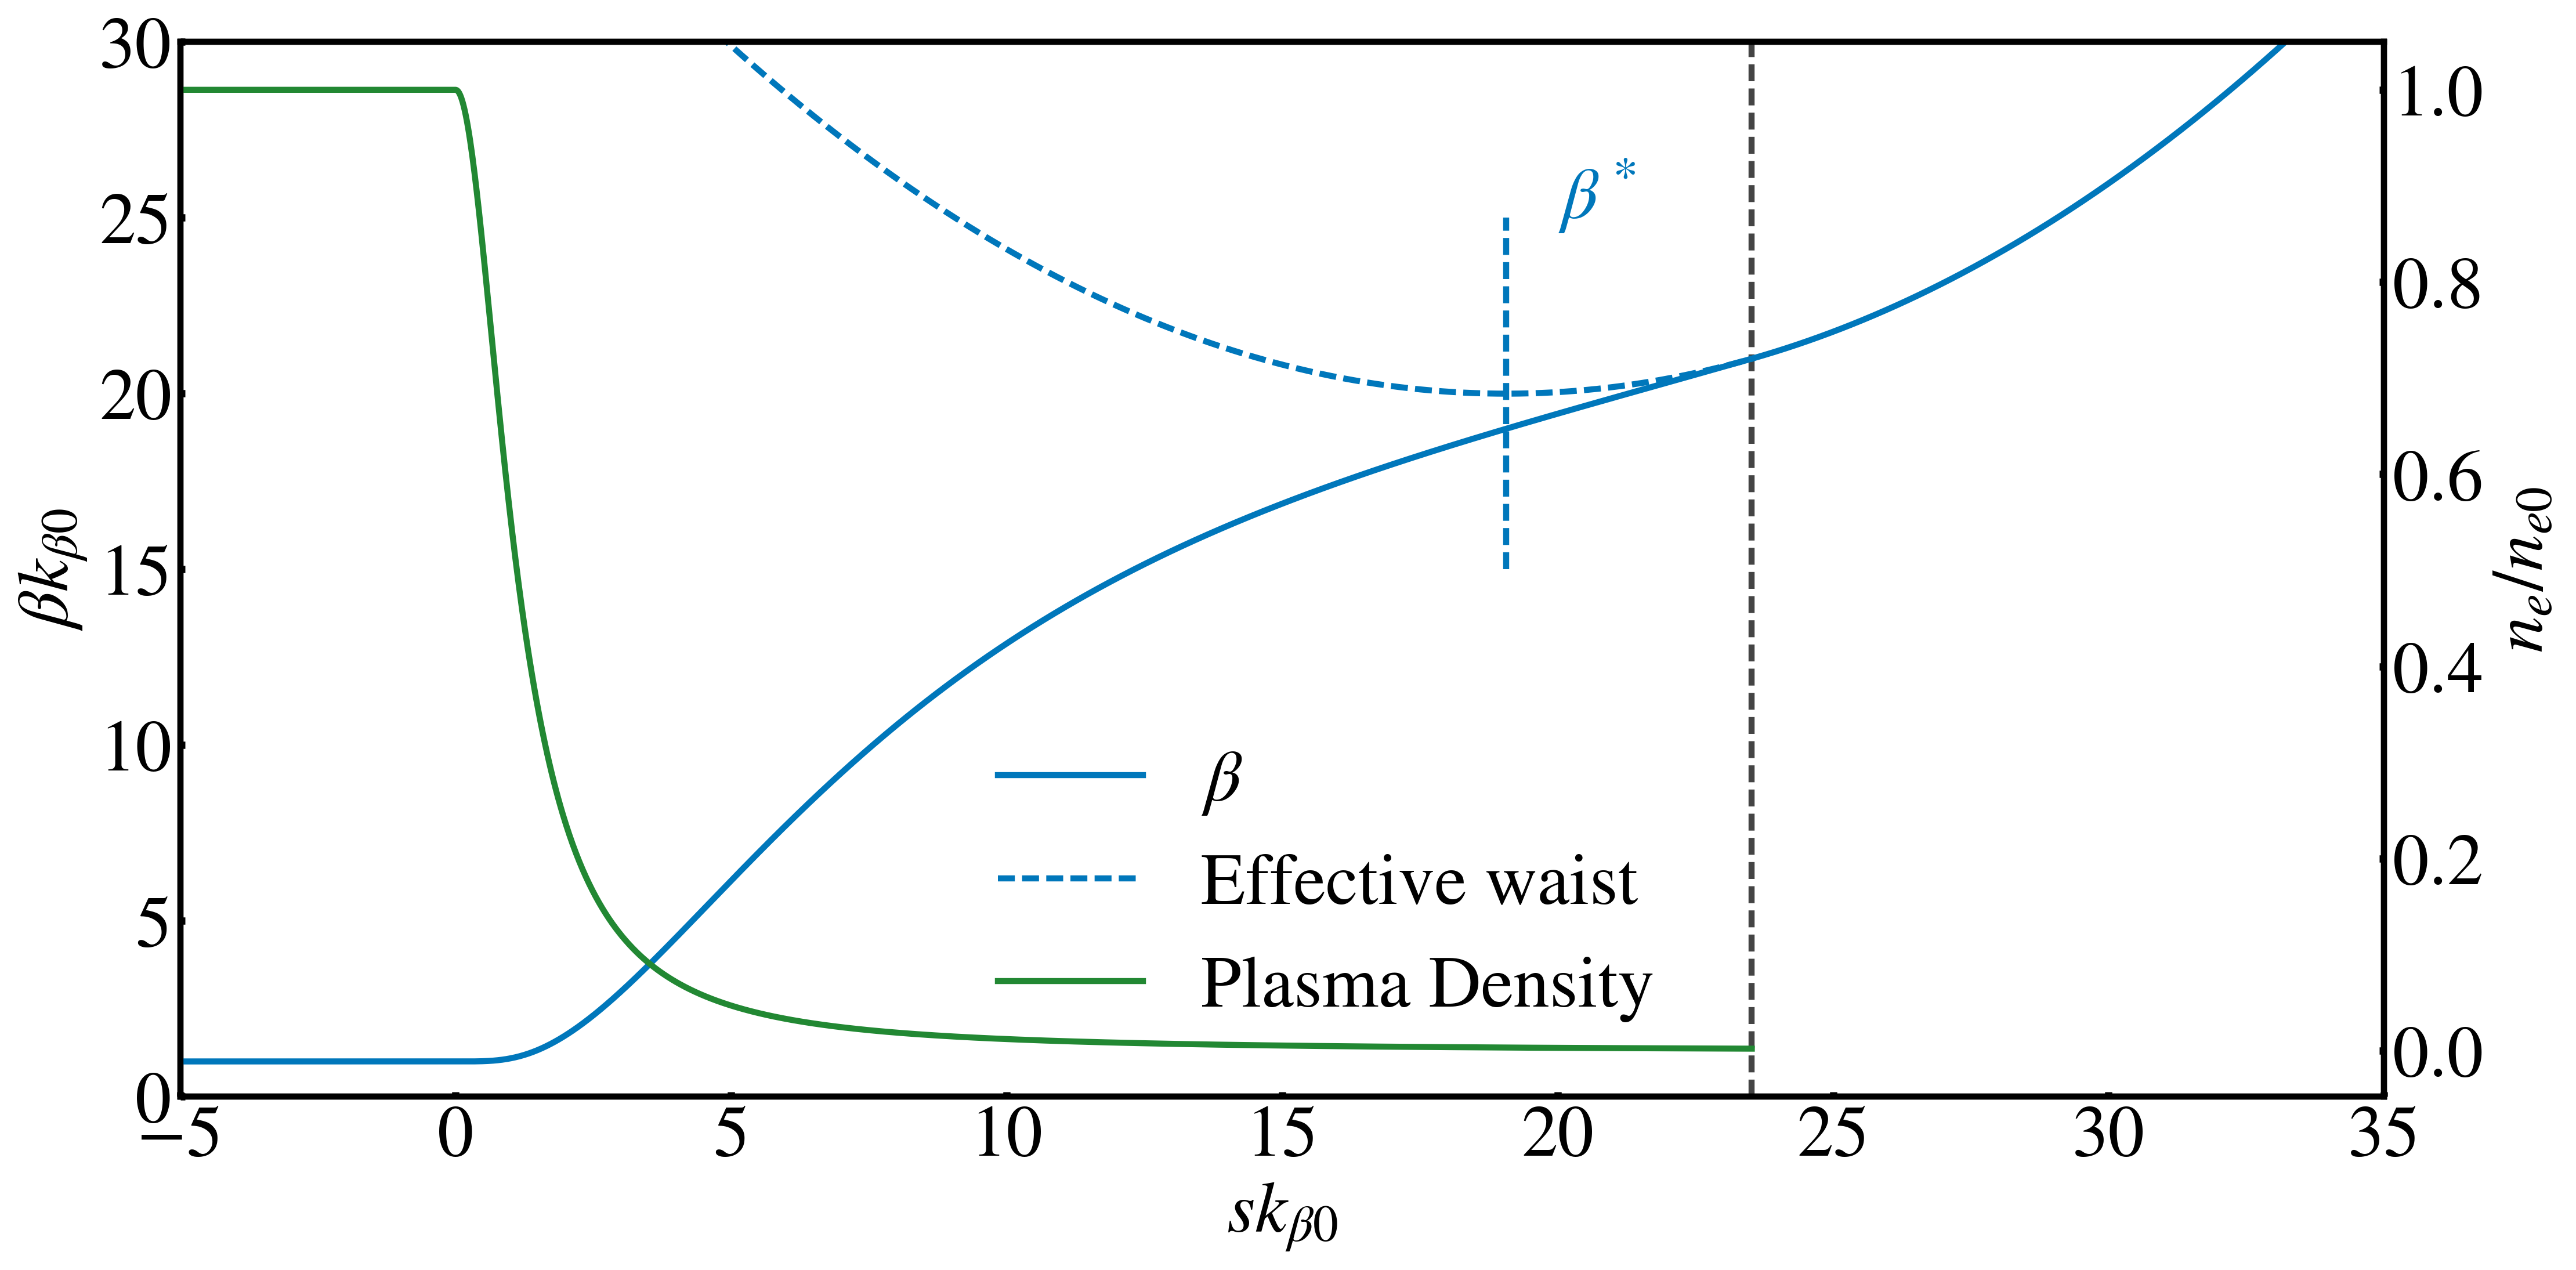

In [8]:
# Exit ramp
N = 10000
Zmax = 175
Zmin = -25
beta0 = 1
alpha0 = 0
gamma0 = (1+alpha0**2)/beta0
gb0 = 20000
ne0 = 2*gb0/5.95074e4**2
dgdz0 = 0.0
a = 0.9
alpham = -a/2
print("alpha_m=", -a/2)
z, dz = np.linspace(Zmin, Zmax, N, retstep=True)
frac = 1/(1+(a*z)**2)
frac[z<0] = 1.0
betam = 1/np.sqrt(frac)
ne = frac*ne0
beta, alpha, gamma, gb = ecalc.cs_propagation(z, ne, beta0, alpha0, gb0, dgdz0, ne0)

# Lowest order adiabatic solution
c0 = 0.5*(beta0+gamma0)
c1 = 0.5*(beta0-gamma0)
c2 = -alpha0
theta = np.cumsum(1/betam)*dz
beta_adi = betam*(c0+c1*np.cos(2*theta)+c2*np.sin(2*theta))

# Waist size along the ramp
betas = 1/np.array(gamma)
sel = betas < 20
sel2 = betas >= 20
tranz = z[sel]
tran = tranz[-1]
print(tran)
bs = betas[sel][-1]
ss = tran+np.array(alpha)[sel][-1]*bs
betaFree = (z-ss)**2/bs+bs

zp = np.linspace(Zmin, Zmax, N)
fig = plt.figure(figsize=(15.5, 8), dpi=300)
ax1 = plt.subplot(111)
ln1 = plt.plot(zp[sel], np.array(beta)[sel], label=r'$\beta$', zorder=10)
ln2 = plt.plot(zp[sel], betaFree[sel], '--', c=blue, label='Effective waist')
plt.plot(zp[sel2], betaFree[sel2], c=blue)
plt.plot([tran, tran], [0, 50], '--', c=grey, zorder=0, label=None)
#plt.plot([ss-tran, ss-tran], [0, 50], '--', c=grey, zorder=0, label=None)
plt.xlabel(r'$s k_{\beta0}$')
plt.ylabel(r'$\beta k_{\beta0}$')
plt.ylim(0, 30)
ax1.plot([ss, ss], [15, 25], '--', color=blue, zorder=0)
plt.text(20, 25, r'$\beta^*$', color=blue)

# Plasma density axis
ax2 = plt.twinx()
ln3 = ax2.plot(zp[sel], frac[sel], '-', color=green, label='Plasma Density')
plt.ylabel(r'$n_e/n_{e0}$')

plt.xlim(-5, 35)
ax1.tick_params(top=False,bottom=True,left=True,direction='in',length=2)
ax2.tick_params(top=False,bottom=True,left=False,right=True,direction='in',length=2)

lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
leg = ax1.legend(lns, labs, frameon=False, bbox_to_anchor=(.52, .2), loc='center')

plt.tight_layout()
plt.savefig(folder+'Exit_Ramp.eps')
plt.savefig(folder+'Exit_Ramp.png')
plt.show()

In [9]:
# Store the variables we need for the full ramp picture
sel = np.logical_and(sel, zp>=0)
z_ext = zp[sel]
beta_ext = np.array(beta)[sel]
frac_ext = frac[sel]
ss_ext = ss
bs_ext = bs

In [7]:
# Entrance ramp, accelerating plasma, exit ramp
# Use the ramp solutions from above for consistency
# Combine the two ramps into a single beta function
N_ent = len(z_ent)
N_ext = len(z_ext)
N_blk = 1000
L = 100 # Length of the bulk plasma
N = N_ent + N_ext + N_blk
z = np.zeros(N)
z[:N_ent] = z_ent
z[N_ent:N_ent+N_blk] = np.linspace(0, L, N_blk)
z[N_ent+N_blk:] = z_ext*np.sqrt(2)+L

frac = np.zeros(N)
frac[:N_ent] = frac_ent
frac[N_ent:N_ent+N_blk] = np.ones(N_blk)
frac[N_ent+N_blk:] = frac_ext
# Remove the very low density front of the plasma
sel = frac < 1e-3
frac[sel] = -1
z_ent0 = z[sel][-1]
z_ext0 = z[-1]

beta = np.zeros(N)
beta[:N_ent] = beta_ent
beta[N_ent:N_ent+N_blk] = np.sqrt(np.linspace(1, 2, N_blk))
beta[N_ent+N_blk:] = beta_ext*np.sqrt(2)

# Vacuum beam propagation
z_vac = np.linspace(-100, 200, 2000)
ss_extc = ss_ext*np.sqrt(2)+L
bs_extc = bs_ext*np.sqrt(2)
bv_ent = (z_vac+ss_ent)**2/bs_ent+bs_ent
bv_ext = (z_vac-ss_extc)**2/bs_extc+bs_extc

# Now we need an emittance in the plasma to go to beam envelope
emt = np.ones(N)
emt[N_ent:N_ent+N_blk] = np.linspace(1, 2, N_blk)
emt[N_ent+N_blk:] = 2

# From this we need the beam envelope
r = np.sqrt(beta/emt)
rv_ent = np.sqrt(bv_ent)
rv_ext = np.sqrt(bv_ext/2)

# Next load everything for the wakefield image
path = '/mnt/md0/VSim/Matched_Accelerating_Gradient/Witness_Beam_Delay/5e16PlasmaDensity_18umWitness/115um/'
simName = 'AccelGradient'

# Load in plasma density
rho, rhoAttrs = load.load_field(path, simName, 'rhoPlasma')
Nx, Ny, Nz = analyze.get_shape(rho[5])
rhoXY = -np.transpose(rho[5][:, :, int(Nz+1)/2, 0]/e/1e6)+2 #+2 makes it greater than 0 for log scale
x = np.linspace(0, 250, Nx)
y = np.linspace(0, 250, Ny)

#Load in drive beam density
rho, rhoAttrs = load.load_field(path, simName, 'rhoDrive')
Nx, Ny, Nz = analyze.get_shape(rho[5])
rhoBXY = -np.transpose(rho[5][:, :, int(Nz+1)/2, 0]/e/1e6)

#Load in witness beam density
rho, rhoAttrs = load.load_field(path, simName, 'rhoWitness')
Nx, Ny, Nz = analyze.get_shape(rho[5])
rhoWXY = -np.transpose(rho[5][:, :, int(Nz+1)/2, 0]/e/1e6)

def alpha_colormap(cmap, cutoff, flip=True):
    N = cmap.N
    cmapt = cmap(np.arange(N))
    alpha = np.ones(N)
    if flip:
        temp = alpha[:int(cutoff*N)]
        M = len(temp)
        alpha[:int(cutoff*N)] = np.linspace(0, 1, M)
    else:
        alpha[int((1-cutoff)*N):] = 0.0
    cmapt[:, -1] = alpha
    cmapt = colors.ListedColormap(cmapt)
    return cmapt

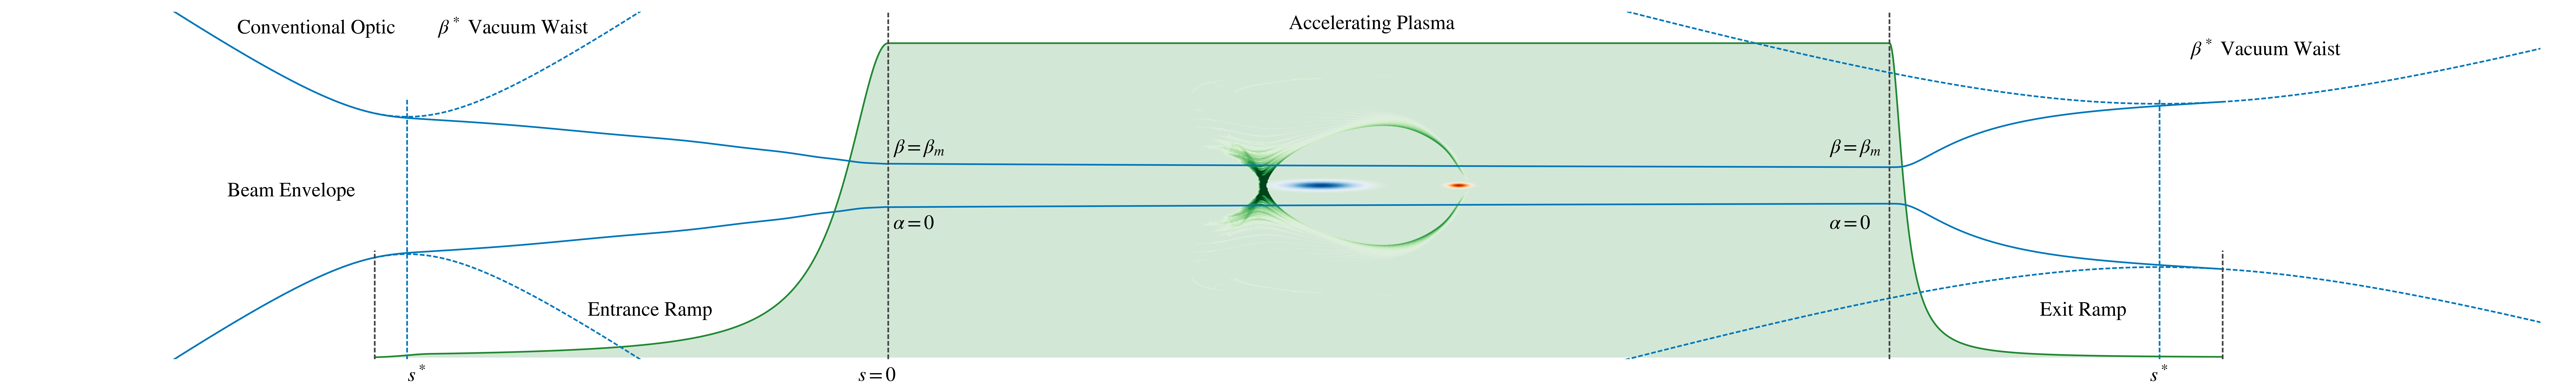

In [31]:
plt.figure(figsize=(48, 8), dpi=300, frameon=False)
plt.plot(z, frac, c=green, zorder=1)
plt.fill_between(z, 0.0, frac, where=frac>=0.0, alpha = 0.2, facecolor='#228833', zorder=0)
plt.ylim(-0.005, 1.1)
plt.axis('off')

ylim = [-8, 8]
ax = plt.twinx()
# Top half of the beam envelope
plt.plot(z, r, c=blue)
plt.plot(z_vac, rv_ent, '--', c=blue)
plt.plot(z_vac, rv_ext, '--', c=blue)
# Bottom half of the beam envelope
plt.plot(z, -r, c=blue)
plt.plot(z_vac, -rv_ent, '--', c=blue)
plt.plot(z_vac, -rv_ext, '--', c=blue)
plt.ylim(ylim)

# Plot the little wakefield bit
# Plot the drive beam
cmapD = alpha_colormap(plt.cm.get_cmap('Oranges'), 0.1, True)
ax.imshow(rhoBXY, interpolation='gaussian', extent=[30, 60, -6, 6], cmap=cmapD)

# Plot the witness beam
cmapW = alpha_colormap(plt.cm.get_cmap('Blues'), 0.1, True)
ax.imshow(rhoWXY, interpolation='gaussian', extent=[30, 60, -10, 10], cmap=cmapW)

# Plot the plasma density
cmapP = alpha_colormap(plt.cm.get_cmap('Greens'), 0.2, True)
ax.imshow(rhoXY, interpolation='gaussian', aspect='auto', extent=[30, 60, -6, 6],
           norm=colors.LogNorm(vmin=6e16, vmax=4e17), cmap=cmapP)

# Vertical lines denoting useful things
# Vacuum waists
plt.plot([-ss_ent, -ss_ent], [ylim[0], 4], 'k--', c=blue)
plt.plot([ss_extc, ss_extc], [ylim[0], 4], 'k--', c=blue)
# Accelerating section
plt.plot([0, 0], ylim, 'k--', c=grey)
plt.plot([L, L], ylim, 'k--', c=grey)
# Ramp ends
plt.plot([z_ent0, z_ent0], [ylim[0], -3], 'k--', c=grey)
plt.plot([z_ext0, z_ext0], [ylim[0], -3], 'k--', c=grey)

plt.text(-45, 7, r'$\beta^*$ Vacuum Waist')
plt.text(130, 6, r'$\beta^*$ Vacuum Waist')
plt.text(40, 7.2, r'Accelerating Plasma')
plt.text(-30, -6, 'Entrance Ramp')
plt.text(115, -6, 'Exit Ramp')

plt.text(-48, -9, r'$s^*$')
plt.text(126, -9, r'$s^*$')
plt.text(-3, -9, r'$s=0$')
plt.text(0.5, 1.5, r'$\beta=\beta_m$')
plt.text(94, 1.5, r'$\beta=\beta_m$')
plt.text(0.5, -2, r'$\alpha=0$')
plt.text(94, -2, r'$\alpha=0$')
plt.text(-66, -0.5, 'Beam Envelope')
plt.text(-65, 7, 'Conventional Optic')

plt.xlim(-85, 165)
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, top=1, left=-0.04, right=1.04) 
#plt.savefig(folder+'Plasma_Source.eps')
plt.savefig(folder+'Plasma_Source.png')
plt.show()